# Store Sales - Time Series Forecasting
**Description**
Goal of the Competition
In this “getting started” competition, you’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

**File Descriptions and Data Field Information**
* train.csv
    * The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
    * store_nbr identifies the store at which the products are sold.
    * family identifies the type of product sold.
    * sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
    * onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

* test.csv
    * The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
    * The dates in the test data are for the 15 days after the last date in the training data.

* sample_submission.csv
    * A sample submission file in the correct format.

* stores.csv
    * Store metadata, including city, state, type, and cluster.
    * cluster is a grouping of similar stores.

* oil.csv
    * Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

* holidays_events.csv
    * Holidays and Events, with metadata
    * NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Target** 
In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

*Textos foram retirados do próprio site do Kaggle:*  https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

  

## 1) Começando com importação e verificação inicial dos dados

In [1]:
# Verificando quais arquivos estão na pasta .zip (Verificação se todos os listados no texto estão na pasta)
from pathlib import Path
from zipfile import ZipFile

zip_path = Path("store-sales-time-series-forecasting.zip")
out_dir  = Path("data_store_sales")
out_dir.mkdir(parents=True, exist_ok=True)

with ZipFile(zip_path, "r") as zf:
    zf.extractall(out_dir)

list(out_dir.iterdir())


[WindowsPath('data_store_sales/holidays_events.csv'),
 WindowsPath('data_store_sales/oil.csv'),
 WindowsPath('data_store_sales/sample_submission.csv'),
 WindowsPath('data_store_sales/stores.csv'),
 WindowsPath('data_store_sales/test.csv'),
 WindowsPath('data_store_sales/train.csv'),
 WindowsPath('data_store_sales/transactions.csv')]

In [2]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data_store_sales")

# -------------------------
# Arquivos principais
# -------------------------
train = pd.read_csv(
    DATA_DIR / "train.csv",
    parse_dates=["date"],
    dtype={
        "store_nbr": "int16",
        "family": "category",
        "onpromotion": "float32",  
        "sales": "float32"
    }
)

test = pd.read_csv(
    DATA_DIR / "test.csv",
    parse_dates=["date"],
    dtype={
        "store_nbr": "int16",
        "family": "category",
        "onpromotion": "float32"
    }
)

sample_sub = pd.read_csv(DATA_DIR / "sample_submission.csv")

stores = pd.read_csv(
    DATA_DIR / "stores.csv",
    dtype={
        "store_nbr": "int16",
        "city": "category",
        "state": "category",
        "type": "category",
        "cluster": "int8"
    }
)

oil = pd.read_csv(
    DATA_DIR / "oil.csv",
    parse_dates=["date"],
    dtype={"dcoilwtico": "float32"}  
)

holidays = pd.read_csv(
    DATA_DIR / "holidays_events.csv",
    parse_dates=["date"],
    dtype={
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "string",
        "transferred": "boolean"
    }
)

# Checagens rápidas
for name, df in {
    "train": train, "test": test, "stores": stores,
    "oil": oil, "holidays_events": holidays, "sample_submission": sample_sub
}.items():
    print(f"\n>>> {name}")
    print(df.shape)
    print(df.head(3))



>>> train
(3000888, 6)
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0

>>> test
(28512, 5)
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE          0.0
1  3000889 2017-08-16          1   BABY CARE          0.0
2  3000890 2017-08-16          1      BEAUTY          2.0

>>> stores
(54, 5)
   store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13
1          2  Quito  Pichincha    D       13
2          3  Quito  Pichincha    D        8

>>> oil
(1218, 2)
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001

>>> holidays_events
(350, 6)
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             

Explorando um pouco o conjunto *train*

* Lembrete:
    * The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
    * **store_nbr** identifies the store at which the products are sold.
    * **family** identifies the type of product sold.
    * **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
    * **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [4]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8.0
3000887,3000887,2017-08-15,9,SEAFOOD,16.000000,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int16         
 3   family       category      
 4   sales        float32       
 5   onpromotion  float32       
dtypes: category(1), datetime64[ns](1), float32(2), int16(1), int64(1)
memory usage: 77.3 MB


In [6]:
train.describe()
# As colunas com informações relevantes são sales e onpromotion
    ## Outra coisa útil é saber que existem 54 lojas no conjunto

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577758e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.092778e+03,1.217919e+01


In [7]:
#Verificando nº de produtos únicos
train["family"].nunique()

33

In [8]:
#Verificando nº de lojas
train["store_nbr"].nunique()

54

In [9]:
# Verificando entradas nulas
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [10]:
#Coluna id é desnecessária
train = train.drop("id",axis=1)

## 2) Análise exploratória de dados

Para fazer a análise exploratória em Python, irei unir as tabelas train, oil, holidays e stores em um único DataFrame

### 2.1 - Antes de unir, farei um tratamento nas outras tabelas
a) Oil

In [20]:
import numpy as np

In [11]:
print(f"Shape oil.csv: {oil.shape}")
print(f"Datas únicas em train.csv: {train["date"].nunique()}")

Shape oil.csv: (1218, 2)
Datas únicas em train.csv: 1684


In [12]:
oil.head(14)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
5,2013-01-08,93.209999
6,2013-01-09,93.080002
7,2013-01-10,93.809998
8,2013-01-11,93.599998
9,2013-01-14,94.269997


In [13]:
oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999
1217,2017-08-31,47.259998


In [14]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [15]:
oil[oil["dcoilwtico"].isnull() == True]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


Apontamentos:
* Há diferença nas datas contabilizadas, pois não há contabilização do preço nos finais de semana.
* Primeira entrada é nula, vou substituir pelo preço do dia seguinte
* As entradas vazias parecem ser erro de coleta, vou substituir pela média entre dia anterior e seguinte

In [16]:
oil = oil.sort_values("date").reset_index(drop=True)

# Tratar nulos do OIL nas datas EXISTENTES do próprio arquivo
#    - Se os primeiros valores forem nulos, substituir pelo próximo preço
#    - Demais nulos: média entre o valor anterior e o seguinte


# primeiro bloco inicial de NaNs -> preenche com o próximo preço válido
if oil["dcoilwtico"].isna().any():
    # posição do primeiro valor não-nulo
    first_valid_idx = oil["dcoilwtico"].first_valid_index()
    if first_valid_idx is not None and first_valid_idx > 0:
        # aplica bfill apenas no prefixo até o primeiro válido
        oil.loc[:first_valid_idx, "dcoilwtico"] = oil.loc[:first_valid_idx, "dcoilwtico"].bfill()

# demais NaNs internos -> média entre anterior e seguinte (linear interpolation cobre isso)
#     - para 1 único NaN entre dois valores, o resultado é exatamente (prev + next)/2
#     - para sequências de NaNs, a interpolação é linear ao longo do intervalo
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(method="linear", limit_direction="both")

# Segurança: se ainda restar algo nulo (caso extremo), bfill/ffill
oil["dcoilwtico"] = oil["dcoilwtico"].bfill().ffill()


# Completar o calendário diário no intervalo do TRAIN
#    - Preencher datas faltantes com o último preço conhecido (ffill)
#    - Se o início ainda ficar antes do primeiro preço, usar o próximo preço (bfill)


date_min = train["date"].min()
date_max = train["date"].max()

cal = pd.DataFrame({"date": pd.date_range(date_min, date_max, freq="D")})

oil_daily = (cal.merge(oil, on="date", how="left")
               .sort_values("date")
               .assign(dcoilwtico=lambda df: df["dcoilwtico"].ffill())  # datas faltantes recebem último preço
               .assign(dcoilwtico=lambda df: df["dcoilwtico"].bfill())  # se as primeiras datas ficarem nulas, usa o próximo preço
            )

# renomear coluna
oil_daily = oil_daily.rename(columns={"dcoilwtico": "oil_price"})
oil_daily["oil_price"] = oil_daily["oil_price"].astype("float32")


# oil_train: apenas datas presentes no conjunto train


train_dates = pd.Index(train["date"].unique())
oil_train = oil_daily[oil_daily["date"].isin(train_dates)].reset_index(drop=True)

# Checagens rápidas
print(oil.shape, oil_daily.shape, oil_train.shape)
print(oil_daily.head(10))
print(oil_train.head(5))


(1218, 2) (1688, 2) (1684, 2)
        date  oil_price
0 2013-01-01  93.139999
1 2013-01-02  93.139999
2 2013-01-03  92.970001
3 2013-01-04  93.120003
4 2013-01-05  93.120003
5 2013-01-06  93.120003
6 2013-01-07  93.199997
7 2013-01-08  93.209999
8 2013-01-09  93.080002
9 2013-01-10  93.809998
        date  oil_price
0 2013-01-01  93.139999
1 2013-01-02  93.139999
2 2013-01-03  92.970001
3 2013-01-04  93.120003
4 2013-01-05  93.120003


b) Holidays
* Colunas chave:
    * train: date, store_nbr.
    * holidays_events: date, type, locale, locale_name, transferred.
    * stores: store_nbr → (state, city).
        * Precisarei de stores.csv para mapear se há feriado na região da loja
     
* Desconsiderar linhas com *transferred = True* (são a origem movida).

* Trate *type = "Transfer"* como o dia realmente celebrado.

In [17]:
holidays.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [18]:
holidays["type"].nunique

<bound method IndexOpsMixin.nunique of 0         Holiday
1         Holiday
2         Holiday
3         Holiday
4         Holiday
          ...    
345    Additional
346    Additional
347    Additional
348       Holiday
349    Additional
Name: type, Length: 350, dtype: category
Categories (6, object): ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day']>

In [21]:
# 1) Normalizar holidays (remove origem movida; mantém Transfer como celebrado)
hol = holidays.copy()

# remover origem movida
hol = hol[~hol["transferred"].fillna(False)].copy()

# "Tipos" que contam como feriado real (ajuste se quiser incluir/excluir Bridge/Work Day)
REAL_TYPES = {"Holiday", "Additional", "Event", "Transfer"}

hol["is_real_holiday"] = hol["type"].isin(REAL_TYPES).astype("int8")

# 2) Agregar por escopo
# Nacional: por data
nat = (hol[hol["locale"]=="National"]
       .groupby("date", as_index=False, observed=True)
       .agg(is_nat_hol=("is_real_holiday","max")))

# Regional: por data + estado
reg = (hol[hol["locale"]=="Regional"]
       .assign(locale_name=lambda d: d["locale_name"].astype(str))
       .groupby(["date","locale_name"], as_index=False, observed=True)
       .agg(is_reg_hol=("is_real_holiday","max"))
       .rename(columns={"locale_name":"state"}))

# Local: por data + cidade
loc = (hol[hol["locale"]=="Local"]
       .assign(locale_name=lambda d: d["locale_name"].astype(str))
       .groupby(["date","locale_name"], as_index=False, observed=True)
       .agg(is_loc_hol=("is_real_holiday","max"))
       .rename(columns={"locale_name":"city"}))

# 3) Calendário por loja-data (a partir do train) + metadados de loja
cal = (train[["date","store_nbr"]].drop_duplicates()
       .merge(stores[["store_nbr","state","city"]], on="store_nbr", how="left"))

# 4) Juntar escopos
cal = (cal
       .merge(nat, on="date", how="left")
       .merge(reg, on=["date","state"], how="left")
       .merge(loc, on=["date","city"],  how="left"))

# 5) Preencher NaN com 0 e garantir int8
for c in ["is_nat_hol","is_reg_hol","is_loc_hol"]:
    if c in cal:
        cal[c] = cal[c].fillna(0).astype("int8")
    else:
        cal[c] = np.int8(0)

# 6) Construir Holiday (1/0) e locale_flag com prioridade Local > Regional > National
cal["Holiday"] = (cal[["is_nat_hol","is_reg_hol","is_loc_hol"]].max(axis=1)).astype("int8")

cal["locale_flag"] = np.select(
    [
        cal["is_loc_hol"].eq(1),
        cal["is_reg_hol"].eq(1),
        cal["is_nat_hol"].eq(1),
    ],
    ["Local", "Regional", "National"],
    default="0"
)
cal["locale_flag"] = cal["locale_flag"].astype("category")


# 7) Unir ao train (mantém family e demais colunas do train)
train_hol = train.merge(
    cal[["date","store_nbr","Holiday","locale_flag"]],
    on=["date","store_nbr"], how="left"
)

# Segurança: preencher possíveis NaN (se houver lojas sem match em stores)
train_hol["Holiday"] = train_hol["Holiday"].fillna(0).astype("int8")
train_hol["locale_flag"] = pd.Categorical(
    train_hol["locale_flag"].astype("string").fillna("0"),
    categories=["0", "National", "Regional", "Local"],
    ordered=False
)

# Visualizar
train_hol[["date","store_nbr","Holiday","locale_flag"]].head()


,date,store_nbr,Holiday,locale_flag
0,2013-01-01,1,1,National
1,2013-01-01,1,1,National
2,2013-01-01,1,1,National
3,2013-01-01,1,1,National
4,2013-01-01,1,1,National


In [22]:
train_hol.head(10)

,date,store_nbr,family,sales,onpromotion,Holiday,locale_flag
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,1,National
1,2013-01-01,1,BABY CARE,0.0,0.0,1,National
2,2013-01-01,1,BEAUTY,0.0,0.0,1,National
3,2013-01-01,1,BEVERAGES,0.0,0.0,1,National
4,2013-01-01,1,BOOKS,0.0,0.0,1,National
5,2013-01-01,1,BREAD/BAKERY,0.0,0.0,1,National
6,2013-01-01,1,CELEBRATION,0.0,0.0,1,National
7,2013-01-01,1,CLEANING,0.0,0.0,1,National
8,2013-01-01,1,DAIRY,0.0,0.0,1,National
9,2013-01-01,1,DELI,0.0,0.0,1,National


Unindo train_hol com oil

In [23]:
# Merge simples por data
train_hol_oil = (
    train_hol
      .merge(oil_daily[['date', 'oil_price']], on='date', how='left')
)

# Dtypes leves
train_hol_oil['oil_price'] = train_hol_oil['oil_price'].astype('float32')

# Se houver alguma data fora do range do oil_daily e você quiser preencher:
# (geralmente não precisa se você construiu oil_daily cobrindo o range do train)
if train_hol_oil['oil_price'].isna().any():
    # Preenche faltas (primeiro bfill para início do período, depois ffill)
    train_hol_oil = (train_hol_oil
                     .sort_values('date')
                     .assign(oil_price=lambda df: df['oil_price'].bfill().ffill())
                     .sort_values(['date','store_nbr','family'])
                     .reset_index(drop=True))

In [24]:
train_hol_oil.head()

,date,store_nbr,family,sales,onpromotion,Holiday,locale_flag,oil_price
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,1,National,93.139999
1,2013-01-01,1,BABY CARE,0.0,0.0,1,National,93.139999
2,2013-01-01,1,BEAUTY,0.0,0.0,1,National,93.139999
3,2013-01-01,1,BEVERAGES,0.0,0.0,1,National,93.139999
4,2013-01-01,1,BOOKS,0.0,0.0,1,National,93.139999


In [25]:
train_hol_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int16         
 2   family       category      
 3   sales        float32       
 4   onpromotion  float32       
 5   Holiday      int8          
 6   locale_flag  category      
 7   oil_price    float32       
dtypes: category(2), datetime64[ns](1), float32(3), int16(1), int8(1)
memory usage: 71.5 MB


### 2.2 - Análise exploratória

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
base = train_hol_oil.copy()

#### Quem vende mais e qual produto vende mais

In [30]:
# Top famílias e lojas por volume
fam_rank = (base.groupby("family", observed=True)["sales"]
                .sum()
                .sort_values(ascending=False)
                .head(15))
store_rank = (base.groupby("store_nbr")["sales"]
                .sum()
                .sort_values(ascending=False)
                .head(15))

# Heterogeneidade de nível e variância
by_sf = (base.groupby(["store_nbr","family"], observed=True)["sales"]
             .agg(vol="sum", mean="mean", std="std", n="size")
             .reset_index())

In [29]:
fam_rank.head()

family
GROCERY I    343462720.0
BEVERAGES    216954480.0
PRODUCE      122704688.0
CLEANING      97521288.0
DAIRY         64487708.0
Name: sales, dtype: float32

In [32]:
store_rank

store_nbr
44    62087552.0
45    54498012.0
47    50948312.0
3     50481912.0
49    43420096.0
46    41896064.0
48    35933132.0
51    32911490.0
8     30494286.0
50    28653020.0
11    28325558.0
7     26952050.0
9     26409442.0
6     25183680.0
24    23767732.0
Name: sales, dtype: float32

In [31]:
by_sf.head()

,store_nbr,family,vol,mean,std,n
0,1,AUTOMOTIVE,5475.0,3.251188,2.759605,1684
1,1,BABY CARE,0.0,0.000000,0.000000,1684
2,1,BEAUTY,4056.0,2.408551,1.898950,1684
3,1,BEVERAGES,2673769.0,1587.748779,726.870056,1684
4,1,BOOKS,211.0,0.125297,0.536578,1684


* Sobre a Heterogeneidade das famílias exibidas:
    * **AUTOMATIVE**: demanda baixa, porém contínua (média > 0, std moderado)
    * **BABY CARE**: sem vendas no período (série nula)
    * **BEAUTY**: baixa/média, mas relativamente estável
    * **BEVERAGES**: A melhor! Alto nível e alta volatilidade; impacta KPI do modelo
    * **BOOKS**: muitos zeros e picos ocasionais

* Vamos adicionar o **coeficiente de variação** e avaliar taxa de vendas zero

In [33]:
base2 = base.copy()
base2["is_zero"] = (base2["sales"] <= 0).astype("int8")

by_sf = (base2.groupby(["store_nbr","family"], observed=True)
               .agg(vol=("sales","sum"),
                    mean=("sales","mean"),
                    std=("sales","std"),
                    n=("sales","size"),
                    zero_rate=("is_zero","mean"))
               .reset_index())

by_sf["cv"] = by_sf["std"] / by_sf["mean"].replace(0, np.nan)


In [42]:
by_sf.head(10)

,store_nbr,family,vol,mean,std,n,zero_rate,cv
0,1,AUTOMOTIVE,5.475000e+03,3.251188,2.759605,1684,0.131235,0.848799
1,1,BABY CARE,0.000000e+00,0.000000,0.000000,1684,1.000000,NaN
2,1,BEAUTY,4.056000e+03,2.408551,1.898950,1684,0.150831,0.788420
3,1,BEVERAGES,2.673769e+06,1587.748779,726.870056,1684,0.003563,0.457799
4,1,BOOKS,2.110000e+02,0.125297,0.536578,1684,0.924584,4.282451
5,1,BREAD/BAKERY,5.699922e+05,338.475159,111.286293,1684,0.003563,0.328787
6,1,CELEBRATION,1.678600e+04,9.967934,33.235439,1684,0.406770,3.334236
7,1,CLEANING,1.078525e+06,640.454285,218.090714,1684,0.003563,0.340525
8,1,DAIRY,1.054354e+06,626.100952,211.156677,1684,0.003563,0.337257
9,1,DELI,2.070371e+05,122.943634,41.169441,1684,0.003563,0.334864


* De fato, **BOOKS** apresentam demanda intermitente.

### Sazonalidade

In [35]:
tmp = base.assign(
    dow=base["date"].dt.dayofweek,   # dia da semana (0=Seg … 6=Dom)
    dom=base["date"].dt.day,         # dia do mês (1–31)
    month=base["date"].dt.month,     # mês (1–12)
    year=base["date"].dt.year,
    week=base["date"].dt.isocalendar().week.astype(int)
)

# efeito médio por dia da semana (global)
dow_eff = tmp.groupby("dow", observed=True)["sales"].mean()

# por família (útil para ver padrões distintos)
dow_fam = (tmp.groupby(["family","dow"], observed=True)["sales"]
              .mean().unstack("dow").fillna(0))

# sazonalidade mensal
month_eff = tmp.groupby("month", observed=True)["sales"].mean()


In [45]:
overall_mean = base["sales"].mean()
print(overall_mean)

357.7758


In [40]:
# média de sales em cada dia da semana, agregada sobre todas as lojas e famílias.
dow_eff

dow
0    346.544739
1    319.823853
2    332.909393
3    283.540527
4    325.238129
5    433.336487
6    463.085358
Name: sales, dtype: float32

In [46]:
(dow_eff / overall_mean - 1).round(3)  # % acima/abaixo da média

dow
0   -0.031
1   -0.106
2   -0.070
3   -0.207
4   -0.091
5    0.211
6    0.294
Name: sales, dtype: float32

In [39]:
#média de sales daquela família em cada dia
dow_fam.head(10)

dow,0,1,2,3,4,5,6
family,,,,,,,
AUTOMOTIVE,5.487398,5.243189,5.220911,4.979090,5.320833,8.027355,8.431559
BABY CARE,0.114262,0.114784,0.102392,0.090664,0.087191,0.128247,0.136034
BEAUTY,3.451898,3.160928,3.106250,2.792361,3.025926,4.863762,5.609877
BEVERAGES,2294.104248,2065.171631,2072.029541,1842.397705,2135.506592,2995.981934,3295.871826
BOOKS,0.067773,0.066192,0.074923,0.061497,0.071065,0.077993,0.076157
BREAD/BAKERY,461.878510,416.080017,425.062531,376.174774,412.063049,530.436462,621.778809
CELEBRATION,6.443984,6.783976,7.431327,8.064737,9.775695,12.326725,7.771605
CLEANING,1058.831909,969.909790,974.143677,865.487976,952.676453,1317.711060,1368.045166
DAIRY,687.193665,620.372498,665.343933,553.014587,632.756775,855.248718,950.376709


In [47]:
dow_fam_profile = (dow_fam.T / dow_fam.mean(axis=1)).T  # cada família ÷ sua média
print(dow_fam_profile)

dow                                0         1         2         3         4  \
family                                                                         
AUTOMOTIVE                  0.899356  0.859331  0.855680  0.816047  0.872057   
BABY CARE                   1.033944  1.038673  0.926537  0.820407  0.788987   
BEAUTY                      0.928964  0.850659  0.835944  0.751472  0.814328   
BEVERAGES                   0.961539  0.865586  0.868460  0.772213  0.895066   
BOOKS                       0.957248  0.934918  1.058231  0.868600  1.003740   
BREAD/BAKERY                0.996817  0.897975  0.917361  0.811853  0.889306   
CELEBRATION                 0.769785  0.810400  0.887731  0.963397  1.167784   
CLEANING                    0.987347  0.904428  0.908377  0.807056  0.888359   
DAIRY                       0.968988  0.874766  0.938179  0.779787  0.892229   
DELI                        0.973467  0.877086  0.838769  0.796921  0.957553   
EGGS                        1.149912  0.

In [41]:
# média de sales em cada mês, agregada globalmente.
month_eff

month
1     341.921539
2     320.928894
3     352.009308
4     339.199860
5     341.765808
6     353.597839
7     374.219116
8     336.992523
9     362.297424
10    362.407104
11    375.681793
12    453.740356
Name: sales, dtype: float32

In [48]:
(month_eff / overall_mean - 1).round(3)

month
1    -0.044
2    -0.103
3    -0.016
4    -0.052
5    -0.045
6    -0.012
7     0.046
8    -0.058
9     0.013
10    0.013
11    0.050
12    0.268
Name: sales, dtype: float32

Note que:
* Dezembro: vende 26,8% acima da média.
* Novembro: vende 5,0%
* Julho: vende 4,6%
* Fevereiro: vende 10,3% (pior mês)

Intervalos de confiança
* mean: média de sales naquele mês (agregado sobre todos os anos/lojas/famílias).

* se (erro-padrão da média): quão precisa é essa média.

* ci95 = 1.96 × se: meia-largura do IC 95% para a média do mês.

Assim, para cada mês, você tem uma estimativa da média de vendas e um intervalo que quantifica a incerteza dessa média. Além disso, comparando os ICs entre meses, dá pra ter uma noção se um mês parece significativamente maior/menor que outro (ICs que não se sobrepõem sugerem diferença relevante).

In [49]:
def se_mean(x): return x.std(ddof=1)/np.sqrt(len(x))
ci = tmp.groupby("month")["sales"].agg(mean="mean", se=se_mean)
ci["ci95"] = 1.96*ci["se"]


In [50]:
ci

,mean,se,ci95
month,,,
1,341.921539,2.049838,4.017683
2,320.928894,1.967949,3.857179
3,352.009308,2.048400,4.014865
4,339.199860,2.168269,4.249807
5,341.765808,2.049500,4.017020
6,353.597839,2.068467,4.054194
7,374.219116,2.084999,4.086597
8,336.992523,2.012686,3.944865
9,362.297424,2.362901,4.631286


dezembro (12) tem média 453.74 e IC 95% $\approx$ [447.98, 459.50] (453.74 ± 5.76).
Fevereiro (2) $\approx$ [317.07, 324.79]. Como esses ICs não se sobrepõem, dezembro é claramente maior que fevereiro.

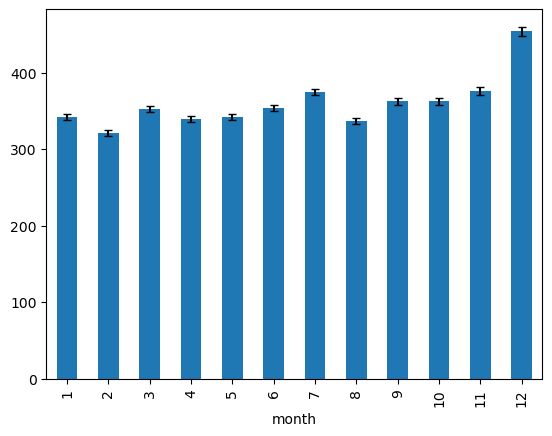

In [51]:
# Ranking com barras de erro
ax = ci['mean'].plot(kind='bar', yerr=ci['ci95'], capsize=3)


### Correlação com petróleo

In [55]:
# agrega vendas diárias e junta petróleo
oil_view = (base.groupby("date")["sales"].sum().to_frame("sales")
               .merge(base[["date","oil_price"]].drop_duplicates("date"),
                      on="date", how="left")
               .sort_values("date"))

# correlação bruta nível-nível
corr_lvl = oil_view[["sales","oil_price"]].corr().iloc[0,1]

# defasagens do petróleo (efeito atrasado)
for k in (1,7,28):
    oil_view[f"oil_lag{k}"] = oil_view["oil_price"].shift(k)
oil_corrs = oil_view[["sales","oil_lag1","oil_lag7","oil_lag28"]].corr().iloc[0,1:]



In [56]:
# Cria defasagens do petróleo: oil_lag1, oil_lag7, oil_lag28 (valor do petróleo 1, 7 e 28 dias antes).
oil_view

,date,sales,oil_price,oil_lag1,oil_lag7,oil_lag28
0,2013-01-01,2511.618896,93.139999,NaN,NaN,NaN
1,2013-01-02,496092.406250,93.139999,93.139999,NaN,NaN
2,2013-01-03,361461.218750,92.970001,93.139999,NaN,NaN
3,2013-01-04,354459.687500,93.120003,92.970001,NaN,NaN
4,2013-01-05,477350.125000,93.120003,93.120003,NaN,NaN
...,...,...,...,...,...,...
1679,2017-08-11,826373.750000,48.810001,48.540001,49.570000,46.529999
1680,2017-08-12,792630.562500,48.810001,48.810001,49.570000,46.529999
1681,2017-08-13,865639.687500,48.810001,48.810001,49.570000,46.529999
1682,2017-08-14,760922.437500,47.590000,48.810001,49.369999,46.020000


In [54]:
# Correlação de Pearson entre nível diário de vendas agregadas e nível diário do petróleo (mesma data).
corr_lvl

np.float64(-0.627110596128596)

correlação negativa forte no nível-nível (quando o petróleo está mais alto, as vendas totais tendem a estar mais baixas, e vice-versa).

In [57]:
oil_corrs

oil_lag1    -0.626235
oil_lag7    -0.621960
oil_lag28   -0.603102
Name: sales, dtype: float64

As correlações seguem negativas e parecidas: indica que, no bruto, o nível do petróleo (atual e recente) se move “ao contrário” do nível de vendas.

### Quebras de nível

In [58]:
# média por ano para ver shifts
by_year = (tmp.groupby(["store_nbr","family","year"], observed=True)["sales"]
              .mean()
              .reset_index()) #Calcula a média anual de vendas para cada série (store_nbr, family)

# lojas/famílias com maior variação ano-a-ano
     ## Para cada (loja, família), pega a maior média anual e a menor média anual e calcula a diferença max − min.
var_year = (by_year.groupby(["store_nbr","family"], observed=True)["sales"]
               .agg(lambda x: x.max()-x.min())
               .sort_values(ascending=False)
               .head(20))
var_year.head(10)


store_nbr  family   
44         PRODUCE      10240.405563
3          PRODUCE       8527.159083
49         PRODUCE       8507.913987
45         BEVERAGES     7038.527588
           PRODUCE       6839.128595
47         BEVERAGES     6704.914062
44         BEVERAGES     6635.873535
47         PRODUCE       6278.571267
3          BEVERAGES     5955.161621
49         BEVERAGES     5822.295410
Name: sales, dtype: float64

44         PRODUCE      10240.405563
3          PRODUCE       8527.159083
49         PRODUCE       8507.913987
45         BEVERAGES     7038.527588

Essas combinações mudaram muito de nível entre anos (mudança estrutural/“shift”).

### Heatmap de sazonalidade

In [63]:
# série por (store,family) resumida semanal (reduz ruído)
weekly = (base.set_index("date")
              .groupby(["store_nbr","family"], observed=True)["sales"]
              .resample("W").sum()
              .reset_index())

# heatmap-like: pivot de vendas por (month x dow)
pivot_md = (tmp.groupby(["month","dow"], observed=True)["sales"].mean()
               .unstack("dow").fillna(0))

In [64]:
# “heatmap tabular” de sazonalidade conjunta mês×dow.
    ## identifica meses/dias com níveis mais altos (ex.: Dezembro × Sáb/Dom).
pivot_md

dow,0,1,2,3,4,5,6
month,,,,,,,
1,345.172668,299.059387,300.986542,256.748871,298.244507,436.819550,462.423950
2,309.485596,290.721619,299.735840,258.344574,299.160522,399.245026,390.381073
3,323.790375,309.162079,340.094055,289.703156,319.579041,425.792969,451.424500
4,315.658478,292.567047,303.380219,271.781158,309.071503,431.527802,449.942383
5,344.046692,310.364838,308.524506,257.570770,308.620483,414.954681,449.785370
6,338.819672,313.107330,325.813721,280.649872,327.081329,431.766235,457.191162
7,361.420410,322.694458,345.246338,298.124359,348.864990,456.772369,487.727783
8,342.783661,319.246338,320.029816,265.626129,308.578735,387.063293,408.699829
9,339.277618,327.172119,339.639832,281.221527,322.925903,446.798798,487.437103
